# Exploratory Data Analysis of US Census Data

## Table of Content
This notebook includes the ETL pipeline creation topic, the cleaned census dataset is stored again in the data directory. The identified actions are used to create pipelines for feature engineering of the different feature types which are needed in the production phase. The goal of the ML task is the **prediction/inference of the salary group** of future people being _<=50K_ or _>50K_. This could be important e.g. for tax questions like the amount of expected tax revenue and its usage for public activities.

It is a simple prediction task, because main project focus are MLOps workflows and its tooling. The ML training implementation is stored in the training directory. During this EDA we can get insights for the ML implementation.

Furthermore, this notebook shall be used for pre-production only, not used in post-production. There the pipelines and app files are in common use.

**Part 1: ETL (Explore-Transform-Load):**<br>
* [1. Data Wrangling](#1.) - with import libraries, gather datasets and first cleaning activities
* [2. EDA](#2.) - with data exploration including statistics and visualisations, starting general feature engineering
* [3. Further Feature Engineering](#3.) - additional feature preparation necessary for our classification task of the US census data
* [4. Load](#4.) - we store the modified dataset as _preproc_census.csv_ file, but not as such type in the associated GitHub repository. There dvc is used for versioning.

---

## Part 1: ETL

<a id='1.'></a>
### 1. Data Wrangling
In this section of the project, after libraries import, logging concept is set, the dataset is loaded, a brief overview of the data structure is given and its general properties are checked. Cleaning is started.

In [1]:
#
#  imports
#
import re
import sys
import numpy as np
import pandas as pd
import logging
import logging.config
import yaml
import pylab
import scipy.stats as stats
from scipy.stats import normaltest
from ydata_profiling import ProfileReport

# for visualisations
from IPython.display import display # Allows use of display() for DataFrames
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator, ScalarFormatter
# plotted graphics appear in the notebook just after current cell
%matplotlib inline  

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", 
                        category = Warning,
                        module = "matplotlib")

In [2]:
# 
# config file
#
CONFIG_FILE = '../../config/config.yml'

In [98]:
# read config file and set logging properties for this eda notebook
with open(CONFIG_FILE, 'r') as f:
    try:
        config = yaml.safe_load(f.read())
        logging.config.dictConfig(config['logging'])
    except yaml.YAMLError as exc:
        print(f'Cannot create config file for eda notebook: {exc}')

# get logger directly (we use staging, knowing that file&console concepts work)
try:
    logging.config.dictConfig(config['logging'])
    logger = logging.getLogger('staging')   
except yaml.YAMLError as exc:
    print(f'Cannot creat logger for eda notebook: {exc}')

# get rid of matplotlib messages
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.category').disabled = True

In [4]:
# If necessary during coding: 
# which kind of pandas and other libs are we using?
# what kind of encoding exists
logger.info(f"installed system versions from eda notebook: \
            {pd.show_versions(str(config['logging']['handlers']['file']['filename']))}")

/home/ilona/miniconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


2023-08-25 15:52:40,983 - MainThread - staging - INFO - installed system versions from eda notebook:             None - 4


In [5]:
# for writing much nicer print strings in this notebook use escape code
def esc(code):
    '''
    Returns the string visualisation code formatting with proper start and ending. 
    Some configuration examples for foreground character formatting are:
    - HEADER = '\033[95m'
    - BLUE = '\033[34m'
    - RED = '\033[91m'
    - GREEN = '\033[92m'
    - YELLOW = '\033[93m'
    - BLUE = '\033[94m'
    - PURPLE = '\033[95m'
    - CYAN = '\033[96m'
    - LIGHTGREY = '\033[97m'
    - BLACK = '\033[98m'   default colour setting
    - WARNING = '\033[93m'
    - FAIL = '\033[91m'
    - END = '\033[0m'
    - BOLD = '\033[1m'
    - UNDERLINE = '\033[4m'
    '''
    return f'\033[{code}m'

In [6]:
# get original US census data csv filen (comma separator)
try:
    df_census_orig = pd.read_csv(str(config['etl']['orig_census']))
    logger.info("\n'US census' orig dataset has {} samples with {} features each".\
                format(*df_census_orig.shape))
except Exception:
    logger.exception("US census orig dataset could not be loaded. Is it missing?")

2023-08-25 15:52:41,086 - MainThread - staging - INFO - 
'US census' orig dataset has 32561 samples with 15 features each - 4


In [7]:
df_census_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlgt           32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**Note:** No null values exists for each column. All have 32561 entries.

In [8]:
df_census_orig.head()

age          workclass   fnlgt   education   education-num  \
0   39          State-gov   77516   Bachelors              13   
1   50   Self-emp-not-inc   83311   Bachelors              13   
2   38            Private  215646     HS-grad               9   
3   53            Private  234721        11th               7   
4   28            Private  338409   Bachelors              13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

    capital-gain   capital-loss   hours-per-week  native-country  salary  
0           2174              0               40   United-States   <=50K  
1              0              0               13   United-States   <=50K  
2              0              0               40   United-States   <=50K  
3              0              0               40   United-States   <=50K  
4              0              0               40            Cuba   <=50K

In [9]:
df_census_orig.describe().style.highlight_max(color='red')

In [10]:
# create profiling report of original census data
profile = ProfileReport(df_census_orig,
                        title=str(config['eda']['orig_report_title']))

In [11]:
profile.to_file(str(config['eda']['orig_census_report']))
logger.info(f"EDA report stored as {config['eda']['orig_census_report']}.")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

2023-08-25 15:53:00,021 - MainThread - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0f443ad70> - 857


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

2023-08-25 15:53:02,523 - MainThread - staging - INFO - EDA report stored as ./eda_census_orig_report.html. - 2


<a id='2.'></a>
### 2. EDA
Now, we start with general preprocessing, like rename columns, removing duplicates if available and modifications regarding the insights of the created profiling report. We have to visualise and understand ou data features before doing detailed feature engineering resp. afterwards building statistical, machine learning models for our prediction goal.

#### 2.1 General Aspects

In [12]:
# preserve the original file
df_orig_copy = df_census_orig.copy()

In [13]:
# are there duplicate rows? If yes, remove them.
df_orig_copy.drop_duplicates(inplace=True, ignore_index=False)

In [14]:
df_orig_copy.duplicated().sum()

0

In [15]:
# how do the column labels look like?
df_orig_copy.columns

Index(['age', ' workclass', ' fnlgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' salary'],
      dtype='object')

In [16]:
# it is common to use underscores in column names and to remove leading/ending spaces
columns = df_orig_copy.columns
df_orig_copy.columns = [col.replace('-', '_').strip() for col in columns]

In [17]:
# after column names modification
df_orig_copy.columns

Index(['age', 'workclass', 'fnlgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'salary'],
      dtype='object')

Now, here are some **general visualisation plots** ... we start with univariate ones. Plots are stored in the _plots_ dir as jpg, because only with that image format they are not cropped compared to e.g. png images.

In [18]:
def plot_categorical_hist(title, xlabel, ylabel, feature_name, size=(4, 2.5)):
    ''' Plots a histogram of the given categorical census attribute. '''
    fig = plt.figure(figsize=size)
    title = fig.suptitle(title, fontsize=10, fontweight='bold')
    fig.subplots_adjust(top=0.85, wspace=0.3)

    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(xlabel, fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9) 
    ax.tick_params(axis='x', rotation=75)
    census_q = df_orig_copy[feature_name].value_counts()
    census_q = (list(census_q.index), list(census_q.values))
    ax.tick_params(axis='both', which='major', labelsize=7)
    bar = ax.bar(census_q[0], census_q[1], color='steelblue', alpha = 0.7)
    
    # save the plot in plots dir
    plot_name = str(feature_name)+'_plot.jpg'
    #print(config['eda']['plots_path']+str(plot_name))
    plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')

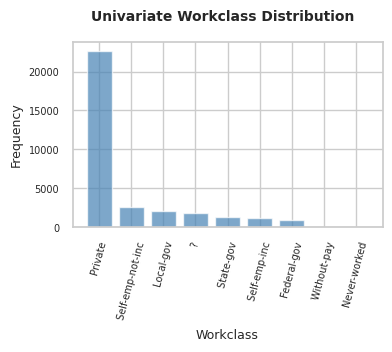

In [19]:
title = 'Univariate Workclass Distribution'
xlabel = 'Workclass'
ylabel = 'Frequency'
feature_name = 'workclass'
plot_categorical_hist(title, xlabel, ylabel, feature_name)

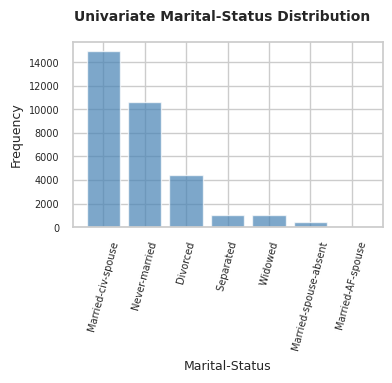

In [20]:
title = 'Univariate Marital-Status Distribution'
xlabel = 'Marital-Status'
ylabel = 'Frequency'
feature_name = 'marital_status'
plot_categorical_hist(title, xlabel, ylabel, feature_name)

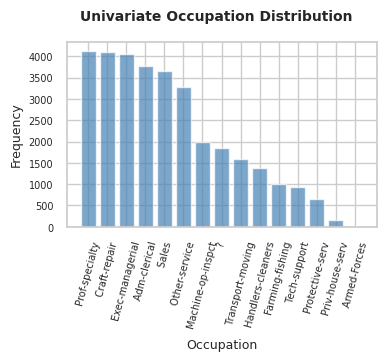

In [21]:
title = 'Univariate Occupation Distribution'
xlabel = 'Occupation'
ylabel = 'Frequency'
feature_name = 'occupation'
plot_categorical_hist(title, xlabel, ylabel, feature_name)

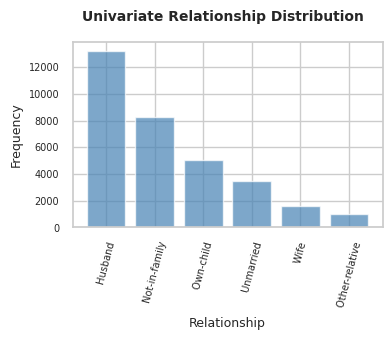

In [22]:
title = 'Univariate Relationship Distribution'
xlabel = 'Relationship'
ylabel = 'Frequency'
feature_name = 'relationship'
plot_categorical_hist(title, xlabel, ylabel, feature_name)

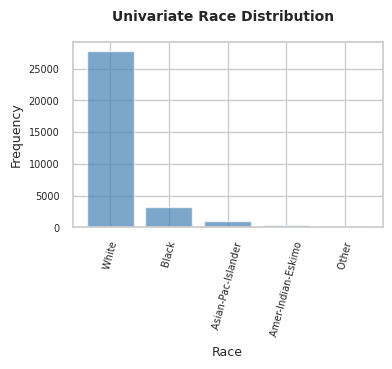

In [23]:
title = 'Univariate Race Distribution'
xlabel = 'Race'
ylabel = 'Frequency'
feature_name = 'race'
plot_categorical_hist(title, xlabel, ylabel, feature_name)

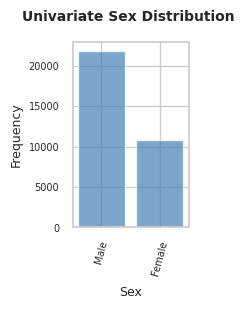

In [24]:
title = 'Univariate Sex Distribution'
xlabel = 'Sex'
ylabel = 'Frequency'
feature_name = 'sex'
size = (1.5, 2.5)
plot_categorical_hist(title, xlabel, ylabel, feature_name, size)

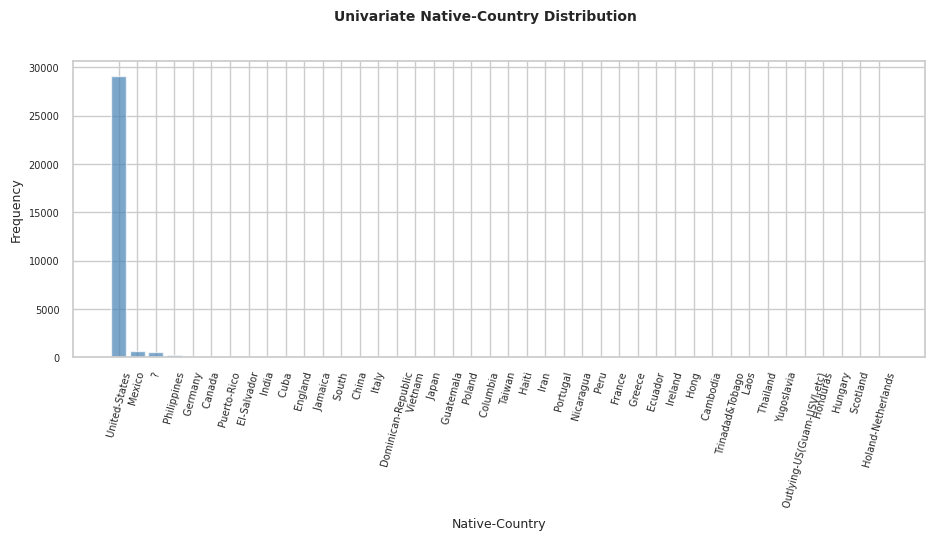

In [25]:
title = 'Univariate Native-Country Distribution'
xlabel = 'Native-Country'
ylabel = 'Frequency'
feature_name = 'native_country'
size = (11, 4)
plot_categorical_hist(title, xlabel, ylabel, feature_name, size)

**Note:** Regarding features value distribution, scaling is important for our ML task.

General Numerical Univariate Feature Distribution



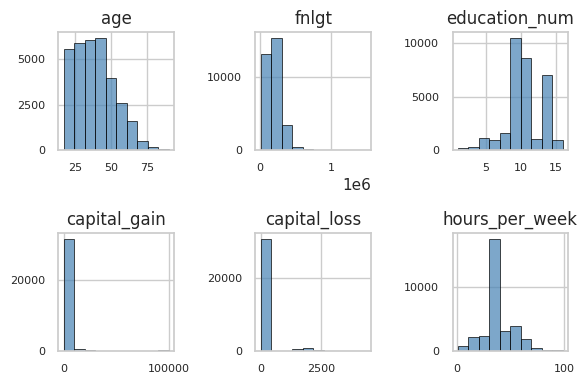

In [26]:
# pandas.plot() has the possibility to add an overall plot title, but plot is ugly
title = 'General Numerical Univariate Feature Distribution\n'
print(esc('4;1') + title + esc(0))
df_orig_copy.hist(bins=10, color='steelblue',
                  edgecolor='black', linewidth=0.7,
                  figsize=(6, 4), layout=(2, 3),
                  xlabelsize=8, ylabelsize=8,
                  grid=True, alpha = 0.7)
plt.tight_layout()
plot_name = 'num_feat_dist_gridplot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show()

**Note:** Regarding the most prominent feature _age_ there exists a right skew.

#### 2.2 Few Specific Features
The profiling report showed a very high correlation between the features _education_ and _education_num_. Because models work with numbers, we remove _education_, but first we get an overview about the mapping of its numbers to the associated categorical feature values.

In [27]:
txt_start = 'Mapping of '
txt_eduno = 'education number'
txt_middle = ' to its '
txt_edustr = 'categorical education string'
txt_end = ' followed by people count for the subgroup:'
print(esc('1') + txt_start + esc('34;1') + txt_eduno + esc('0') + esc('1') + txt_middle + \
      esc('34;1') + txt_edustr + esc('0') + esc('1') + txt_end + esc(0))
df_orig_copy.groupby(['education_num', 'education'])['education'].count()

Mapping of education number to its categorical education string followed by people count for the subgroup:


education_num  education    
1               Preschool          50
2               1st-4th           166
3               5th-6th           332
4               7th-8th           645
5               9th               514
6               10th              933
7               11th             1175
8               12th              433
9               HS-grad         10494
10              Some-college     7282
11              Assoc-voc        1382
12              Assoc-acdm       1067
13              Bachelors        5353
14              Masters          1722
15              Prof-school       576
16              Doctorate         413
Name: education, dtype: int64

**Note:** So, to remember after having removed the education attribute: the higher the number, the higher the level of eduction. Most people of the dataset have a high-school grade education, followed by Bachelors degree. Less have only a very low level education.

It may be worthwhile adding a new feature, called _education_level_num_ communicate the level of education having the following meaning with the precondition not knowing the US education system properly:
- low==1        used for: Preschool, 1st-4th, 5th-6th, 9th
- average==2    used for: 10th, 11th, 12th, HS-grad, Some-college, Assoc-voc, Assoc-acdm
- high==3       used for: Bachelors, Masters, Prof-school, Doctorate

And before doing that, creating some visualisations of the distribution of people regarding education depending on sex, age and race.

In [28]:
df_orig_copy['education_level_num'] = df_orig_copy['education_num']. \
                                        apply(lambda value: 1 
                                                if value < 6 else 2 
                                                    if value < 13 else 3)

In [29]:
df_orig_copy['education_level_num'].unique()

array([3, 2, 1])

In [30]:
df_orig_copy.groupby('education_level_num')['education_level_num'].count()

education_level_num
1     1707
2    22766
3     8064
Name: education_level_num, dtype: int64

Now, we have a look to the age, education, ... attributes relationship

In [31]:
bins=[0, 25, 50, 75, 1000]
labels=['young adults', 'adult', 'older', 'senior']
df_orig_copy['age_group'] = pd.cut(df_orig_copy['age'], bins=bins, labels=labels)

In [32]:
df_orig_copy['age_group'].value_counts()

adult           19678
young adults     6400
older            6219
senior            240
Name: age_group, dtype: int64

In [33]:
bins=[0, 1, 2, 3]
labels = ['low', 'average', 'high']
df_orig_copy['education_level_group'] = pd.cut(df_orig_copy['education_level_num'], bins=bins, labels=labels)

In [34]:
df_orig_copy['education_level_group'].value_counts()

average    22766
high        8064
low         1707
Name: education_level_group, dtype: int64

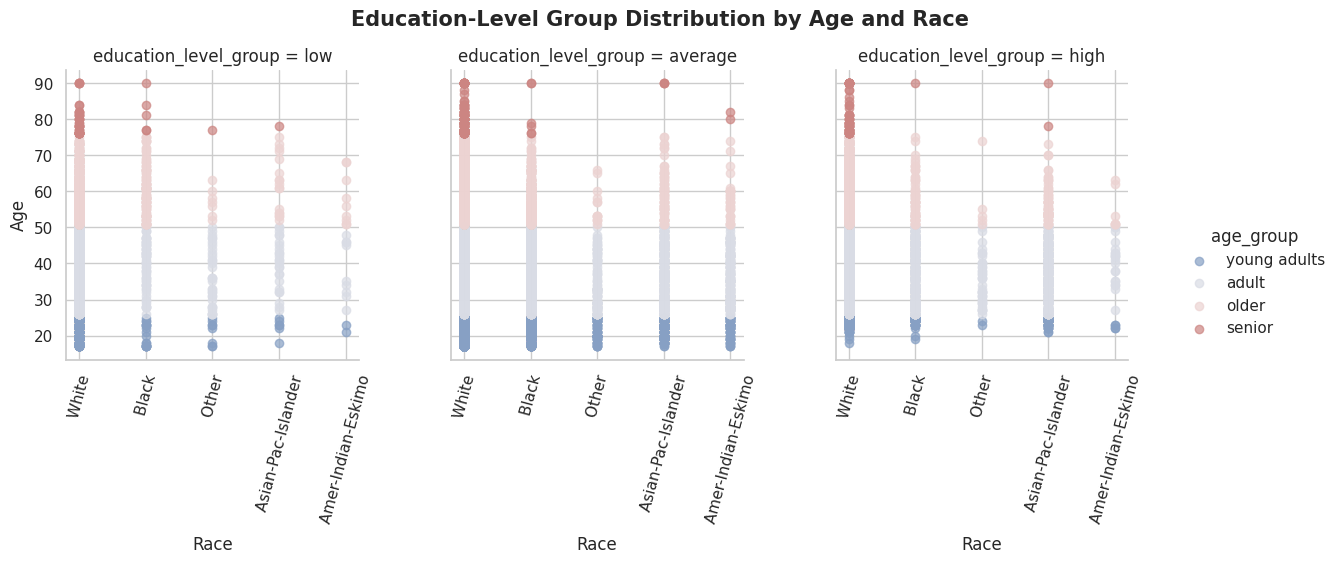

In [35]:
# 3-D graph with continous data using color and facets
title = "Education-Level Group Distribution by Age and Race";

gfg = sns.FacetGrid(df_orig_copy,
                    height=4, aspect=1.0,
                    col='education_level_group', 
                    hue='age_group',
                    margin_titles=True,
                    palette="vlag");
gfg.map(plt.scatter, 'race', 'age', alpha=0.7);

# tweak the visual presentation
gfg.set(xlabel='Race', ylabel='Age')
gfg.fig.suptitle(title, fontsize=15, fontweight='bold', y=1.05)
gfg.tick_params(axis='x', rotation=75)
gfg.add_legend()
plot_name = 'eduLevel_dist_age-race_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show()

In [36]:
# remove education attribute,
# which is highly correlated to the education_num feature
# and because models work with numbers;
# remove additionally created ones used for plot creations as well before ML task!
df_orig_copy.drop(columns=['education'], inplace=True)

In [37]:
df_orig_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32537 entries, 0 to 32560
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    32537 non-null  int64   
 1   workclass              32537 non-null  object  
 2   fnlgt                  32537 non-null  int64   
 3   education_num          32537 non-null  int64   
 4   marital_status         32537 non-null  object  
 5   occupation             32537 non-null  object  
 6   relationship           32537 non-null  object  
 7   race                   32537 non-null  object  
 8   sex                    32537 non-null  object  
 9   capital_gain           32537 non-null  int64   
 10  capital_loss           32537 non-null  int64   
 11  hours_per_week         32537 non-null  int64   
 12  native_country         32537 non-null  object  
 13  salary                 32537 non-null  object  
 14  education_level_num    32537 non-null 

**Question:** Which columns are the ones including object (string) values, so, being **categorical features**?

In [38]:
df_orig_copy_obj = df_orig_copy.select_dtypes(include=['object'])
df_orig_copy_obj.columns.values

array(['workclass', 'marital_status', 'occupation', 'relationship',
       'race', 'sex', 'native_country', 'salary'], dtype=object)

**Note:** We have to take care of this columns during preprocessing, this object (string) datatypes cannot be used for our prediction tasks. Only numbers are allowed. So, at least one-hot-encoding is necessary and scaling is expected.

**Next question:** Are there features including only one single value? If yes, they don't have an added value for the dataset and can be removed.

In [39]:
# get number of unique values for each column
counts = df_orig_copy.nunique()
list_single_card = [col for col,val in enumerate(counts) if val == 1]

if list_single_card:
    logging.info('Remove list_single_card features with cardinality 1')
    logging.info(f'idx values are: {list_single_card}')
    # use the found index values for dataframe columns drop
    df_orig_copy.drop(df_orig_copy.columns[list_single_card], axis=1, inplace=True)
else:
    logging.info('Empty list_single_card: No features with cardinality 1')

2023-08-25 15:53:12,320 - MainThread - root - INFO - Empty list_single_card: No features with cardinality 1 - 11


As we can see with this empty list, there is no feature column having only one single value.
Great, because no missing values per feature attribute are available as well.

**Next question:** How do some of the numerical features look like, what are their values?

In [40]:
df_orig_copy['age'].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87])

In [41]:
df_orig_copy['hours_per_week'].unique()

array([40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 38, 43, 55,
       48, 58, 32, 70,  2, 22, 56, 41, 28, 36, 24, 46, 42, 12, 65,  1, 10,
       34, 75, 98, 33, 54,  8,  6, 64, 19, 18, 72,  5,  9, 47, 37, 21, 26,
       14,  4, 59,  7, 99, 53, 39, 62, 57, 78, 90, 66, 11, 49, 84,  3, 17,
       68, 27, 85, 31, 51, 77, 63, 23, 87, 88, 73, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95])

In [42]:
df_orig_copy['capital_gain'].unique()

array([ 2174,     0, 14084,  5178,  5013,  2407, 14344, 15024,  7688,
       34095,  4064,  4386,  7298,  1409,  3674,  1055,  3464,  2050,
        2176,   594, 20051,  6849,  4101,  1111,  8614,  3411,  2597,
       25236,  4650,  9386,  2463,  3103, 10605,  2964,  3325,  2580,
        3471,  4865, 99999,  6514,  1471,  2329,  2105,  2885, 25124,
       10520,  2202,  2961, 27828,  6767,  2228,  1506, 13550,  2635,
        5556,  4787,  3781,  3137,  3818,  3942,   914,   401,  2829,
        2977,  4934,  2062,  2354,  5455, 15020,  1424,  3273, 22040,
        4416,  3908, 10566,   991,  4931,  1086,  7430,  6497,   114,
        7896,  2346,  3418,  3432,  2907,  1151,  2414,  2290, 15831,
       41310,  4508,  2538,  3456,  6418,  1848,  3887,  5721,  9562,
        1455,  2036,  1831, 11678,  2936,  2993,  7443,  6360,  1797,
        1173,  4687,  6723,  2009,  6097,  2653,  1639, 18481,  7978,
        2387,  5060])

In [43]:
df_orig_copy.groupby('capital_gain')['capital_gain'].count()

capital_gain
0        29825
114          6
401          2
594         34
914          8
         ...  
25236       11
27828       34
34095        5
41310        2
99999      159
Name: capital_gain, Length: 119, dtype: int64

In [44]:
df_orig_copy.groupby('fnlgt')['fnlgt'].count()

fnlgt
12285      1
13769      1
14878      1
18827      1
19214      1
          ..
1226583    1
1268339    1
1366120    1
1455435    1
1484705    1
Name: fnlgt, Length: 21648, dtype: int64

#### 2.3 Classification Target for Prediction/Inference

**Next topic:** We can take care on our **classification target feature**. Because we are analysing census data, the _salary_ feature has the primary focus. By now, it is a categorical feature, so we have to change it to a numerical one used for the classification prediction. What are the salary values?

In [45]:
df_orig_copy['salary'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [46]:
df_orig_copy.groupby('salary')['salary'].count()

salary
 <=50K    24698
 >50K      7839
Name: salary, dtype: int64

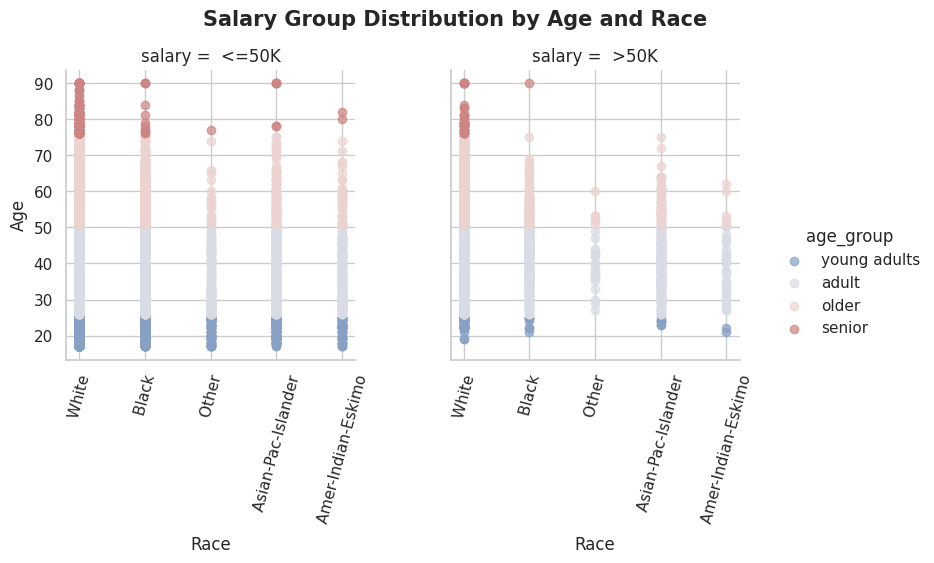

In [47]:
title = "Salary Group Distribution by Age and Race";

gfg = sns.FacetGrid(df_orig_copy,
                    height=4, aspect=1.0,
                    col='salary', 
                    hue='age_group',
                    margin_titles=True,
                    palette="vlag");
gfg.map(plt.scatter, 'race', 'age', alpha=0.7);

# tweak the visual presentation
gfg.set(xlabel='Race', ylabel='Age')
gfg.fig.suptitle(title, fontsize=15, fontweight='bold', y=1.05)
gfg.tick_params(axis='x', rotation=75)
gfg.add_legend()
plot_name = 'salary_dist_age-race_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show()

**Note:** Regarding this US census dataset no surprise, most people with a salary >50k are white with a much higher age range compared to all other race groups. The age group distribution from young adults to older people look nearly the same by having a salary <=50k. There only the senior distribution is different.

Now, we convert the salary strings to its **binary mapping values** _>50K: 1, <=50K: 0_.

In [48]:
df_orig_copy['salary'] = df_orig_copy['salary'].map({' >50K': 1, ' <=50K': 0})

In [49]:
df_orig_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32537 entries, 0 to 32560
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    32537 non-null  int64   
 1   workclass              32537 non-null  object  
 2   fnlgt                  32537 non-null  int64   
 3   education_num          32537 non-null  int64   
 4   marital_status         32537 non-null  object  
 5   occupation             32537 non-null  object  
 6   relationship           32537 non-null  object  
 7   race                   32537 non-null  object  
 8   sex                    32537 non-null  object  
 9   capital_gain           32537 non-null  int64   
 10  capital_loss           32537 non-null  int64   
 11  hours_per_week         32537 non-null  int64   
 12  native_country         32537 non-null  object  
 13  salary                 32537 non-null  int64   
 14  education_level_num    32537 non-null 

#### 2.4 Visualisations
Some additional visualisations ...<br>
First, we have a look to a **boxplot diagram** of the features to detect _outliers_. 

Detecting data **outliers** is important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration for these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use **Tukey's Method** for identifying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

Afterwards, some scatterplots are created.

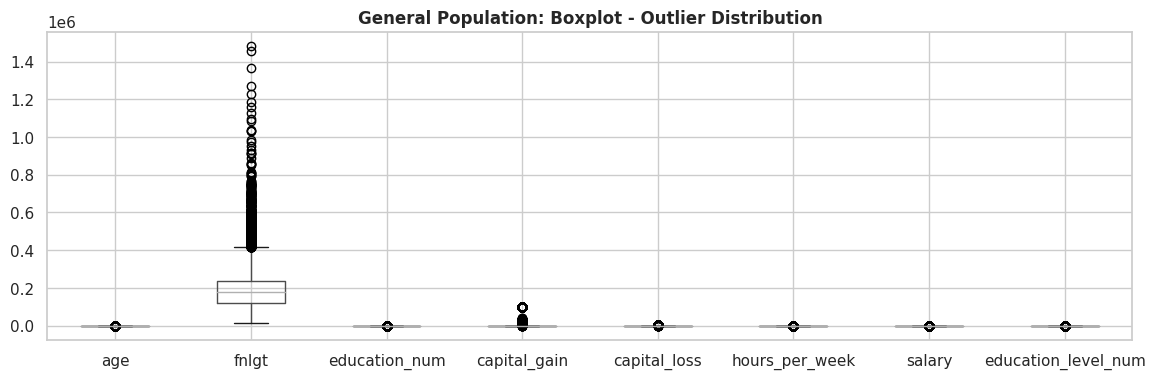

In [50]:
df_orig_copy.boxplot(figsize=(14,4))
plt.title("General Population: Boxplot - Outlier Distribution", fontsize=12, fontweight='bold');

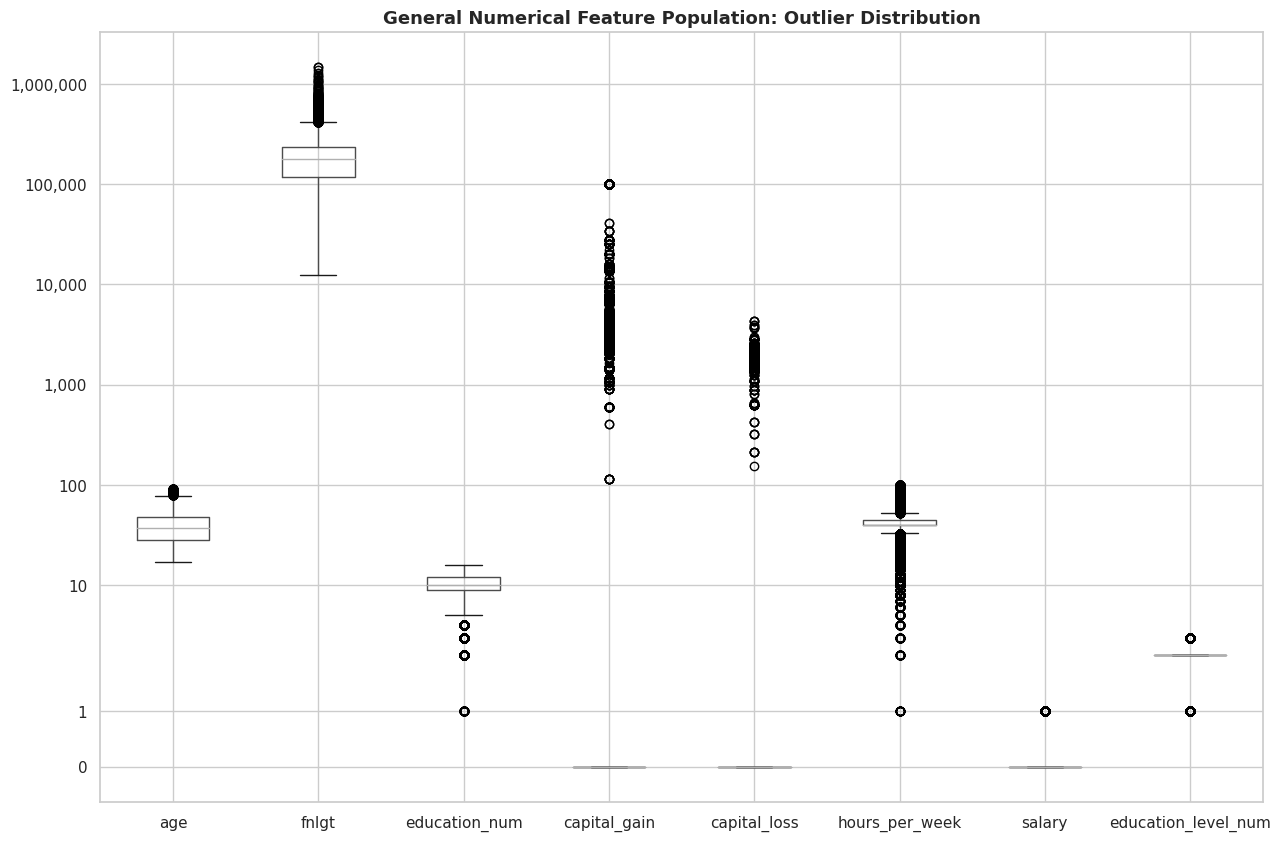

In [51]:
# change the visualisation to log y axis scaling
ax = df_orig_copy.boxplot(figsize=(15, 10))
ax.set_yscale('symlog')  # symlog also allows zero
#ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(lambda x, p: f'{int(x):,}')
ax.yaxis.set_minor_locator(NullLocator())  # remove minor ticks
title = "General Numerical Feature Population: Outlier Distribution"
plt.title(title, fontsize=13, fontweight='bold');

**Note:** The _log scaling_ visualises the value range of the features much better. Small numbers are not squeezed too closely.

In [52]:
num_cat_feats = ['age', 'fnlgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'sex', 'salary']
df_orig_copy_long = df_orig_copy[num_cat_feats].melt(id_vars=['sex'])
df_orig_copy_long.head()

sex variable  value
0     Male      age     39
1     Male      age     50
2     Male      age     38
3     Male      age     53
4   Female      age     28

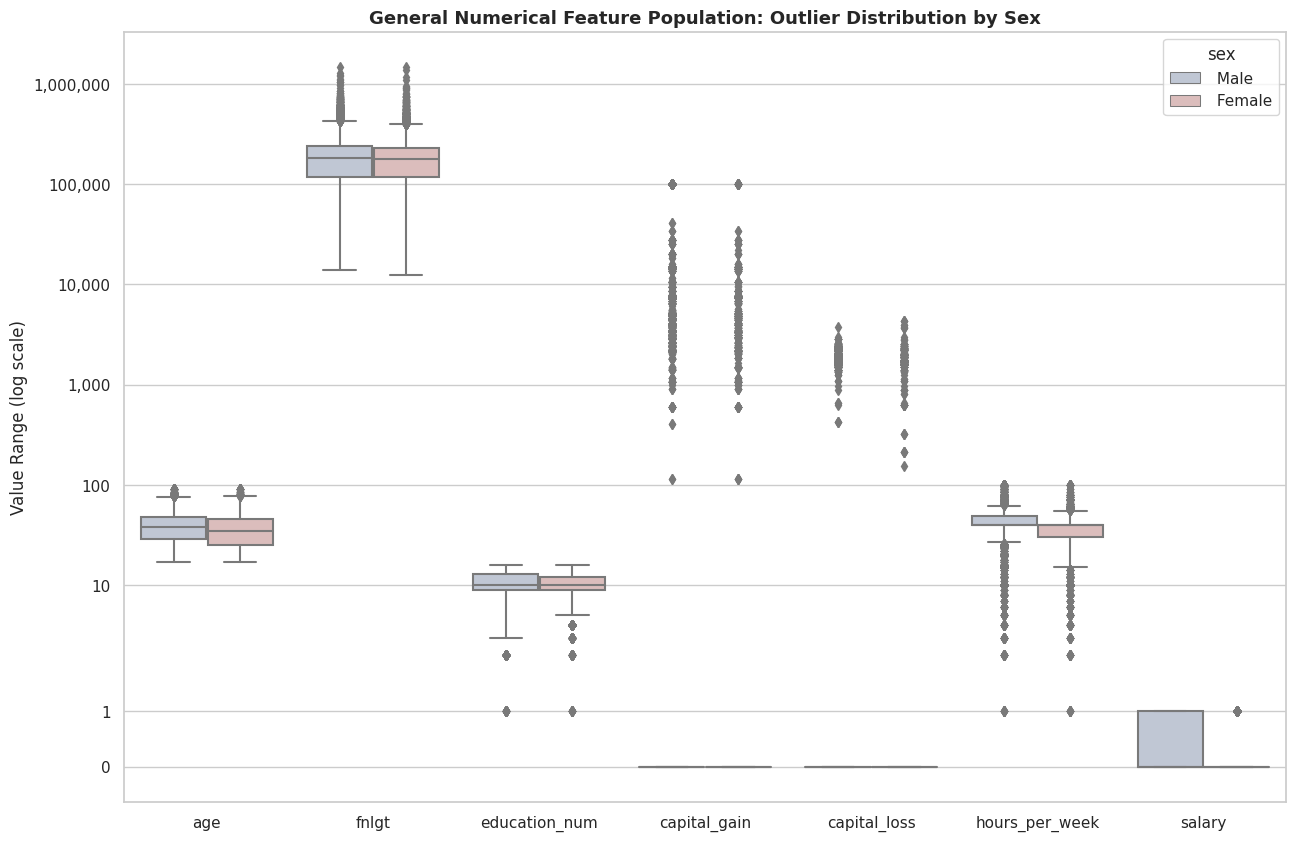

In [53]:
# 3-D mix data using boxplots graphs,
# use hue for categorical sex as third dimension

f, ax = plt.subplots(figsize=(15, 10))
ax.set_yscale('symlog')  # symlog also allows zero
#ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(lambda x, p: f'{int(x):,}')
ax.yaxis.set_minor_locator(NullLocator())  # remove minor ticks
gfg = sns.boxplot(x="variable", y="value", hue="sex",
            data=df_orig_copy_long, palette="vlag", ax=ax)
gfg.set(ylabel='Value Range (log scale)', xlabel='')
title = "General Numerical Feature Population: Outlier Distribution by Sex"
plt.title(title, fontsize=13, fontweight='bold')
plot_name = 'numFeats_outlierDist_sex_boxplot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show()

**Note:** The distribution of male and female samples are not too different in most of the attributes, but on average, women work much less compared to man and regarding the most prominent feature _salary_, man earn much often >50K compared to women. Latter is an outlier event for women.

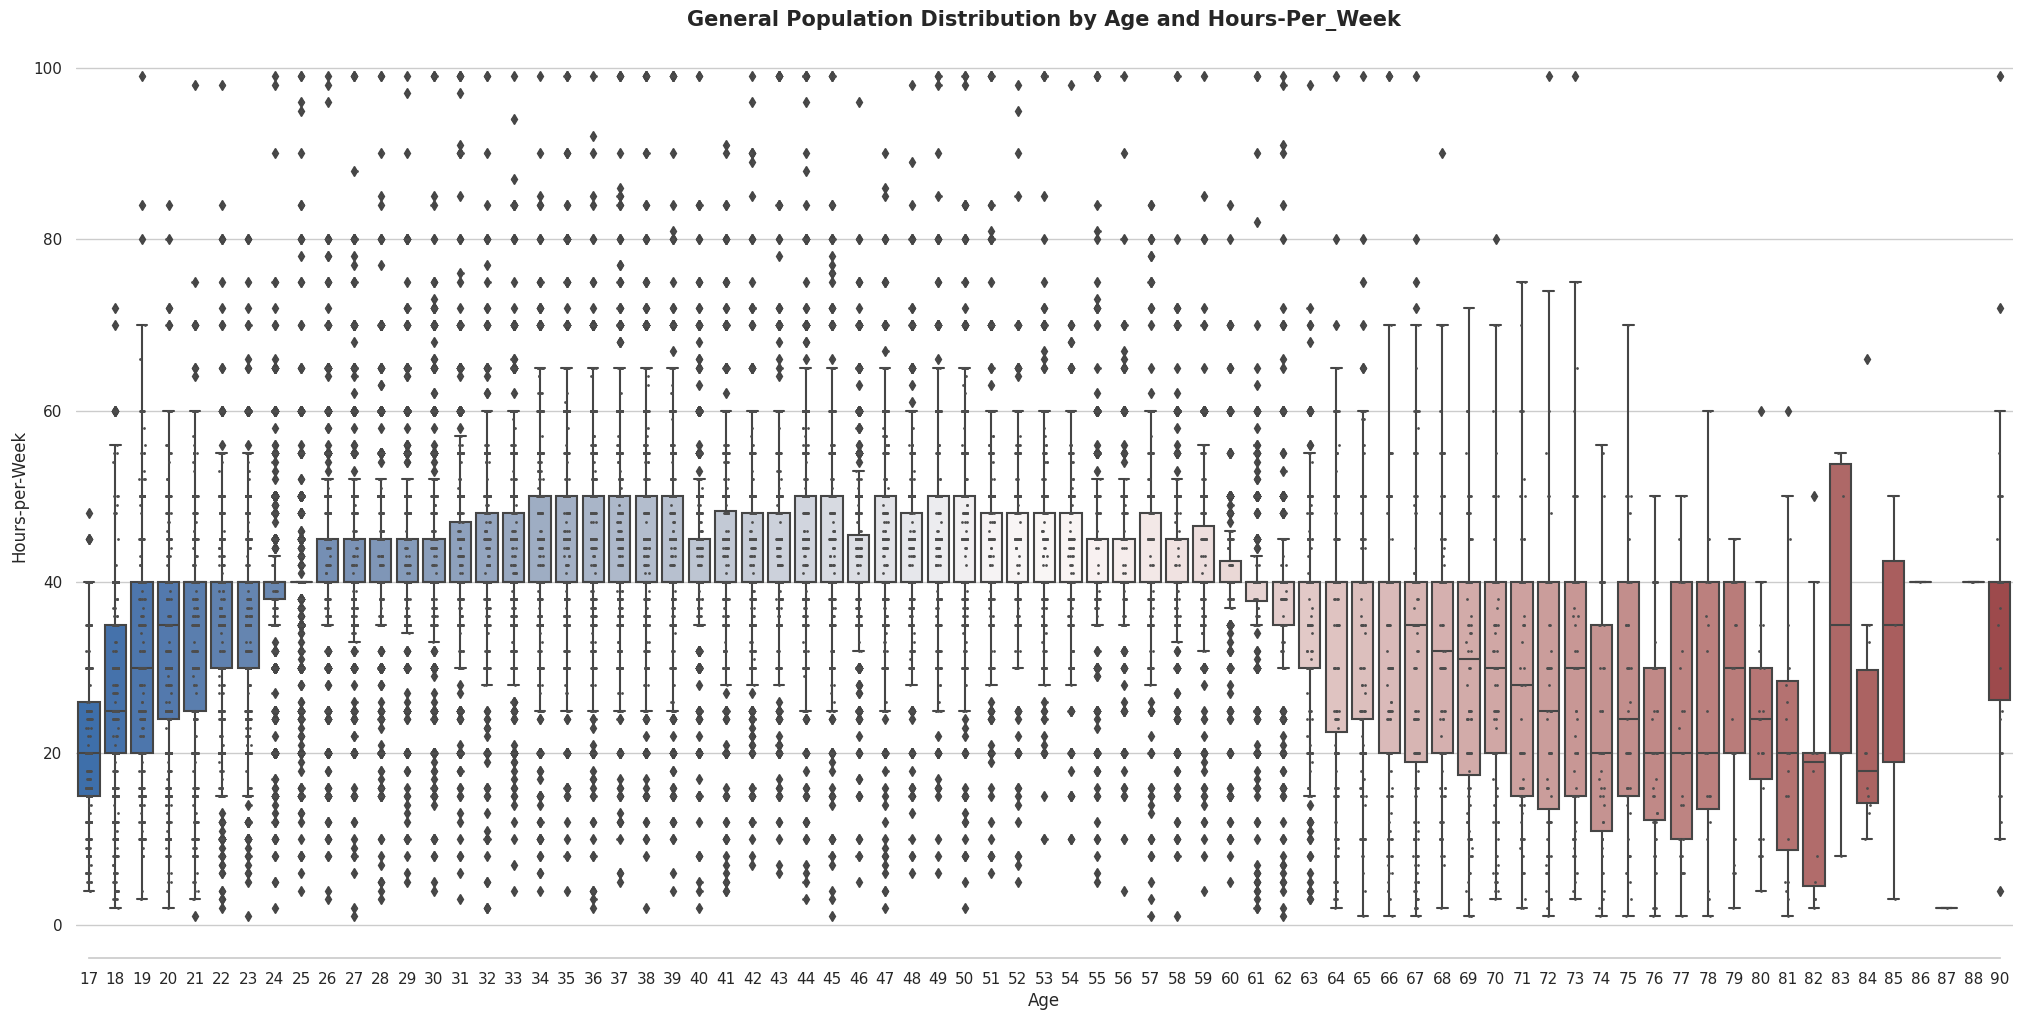

In [54]:
# create figure
plt.figure(figsize=(25,12))
sns.set_theme(style="ticks")
sns.set_style("whitegrid")
gfg = sns.boxplot(x="age", y="hours_per_week", 
            data=df_orig_copy,
            palette="vlag")

# add in points to show each observation
sns.stripplot(x="age", y="hours_per_week", 
              data=df_orig_copy,
              size=2, color=".3", linewidth=0)

# tweak the visual presentation
ax.xaxis.grid(True)
gfg.set(xlabel='Age', ylabel='Hours-per-Week')
sns.despine(trim=True, left=True)
plt.title("General Population Distribution by Age and Hours-Per_Week", fontsize=15, fontweight='bold')
plot_name = 'general_dist_age-hoursPerWeek_boxplot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight');

**Note:** In the age range from 25 up to 60 people work longer than 40 hours-per-week. If a person is much younger or much older, in general, such person works much less.

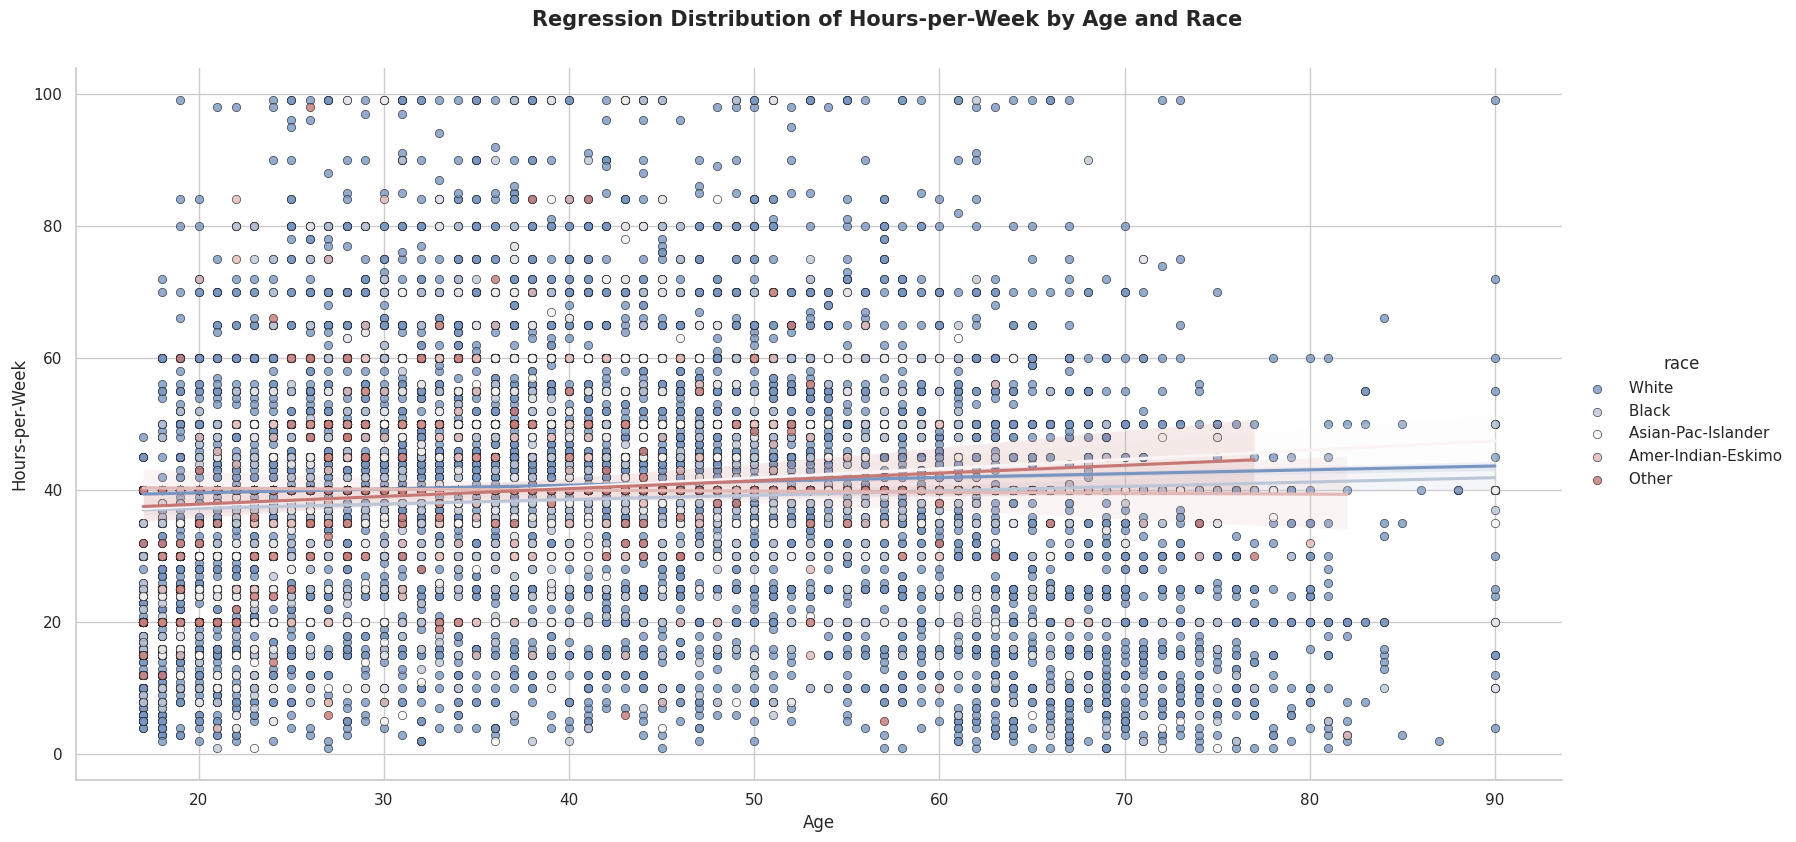

In [55]:
# 3-D mix data using kind of scatter plot graph,
# leveraging the concepts of hue for categorical dimension,                
# view relationships\correlations as needed                  
lplot = sns.lmplot(data=df_orig_copy,
                   x='age', y='hours_per_week',
                   hue='race', height=8, aspect=2,
                   palette="vlag",  # {"red": "#FF9999", "white": "#FFE888"},
                   fit_reg=True, legend=True,
                   scatter_kws=dict(edgecolor="k", linewidth=0.5)) 
lplot.set(xlabel='Age', ylabel='Hours-per-Week')
title = 'Regression Distribution of Hours-per-Week by Age and Race\n\n\n'
lplot.fig.suptitle(title, fontsize=15, fontweight='bold', y=1.05)
plot_name = 'hoursPerWeek-Regression_dist_age-race_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show()

**Note:** In average, US american native people are working more constantly on the same level. With white, black and asian-pacific-islander average people are work longer regarding age >80 and hours >40.

**Next question:** Are age, education and sex be relevant for working hours?

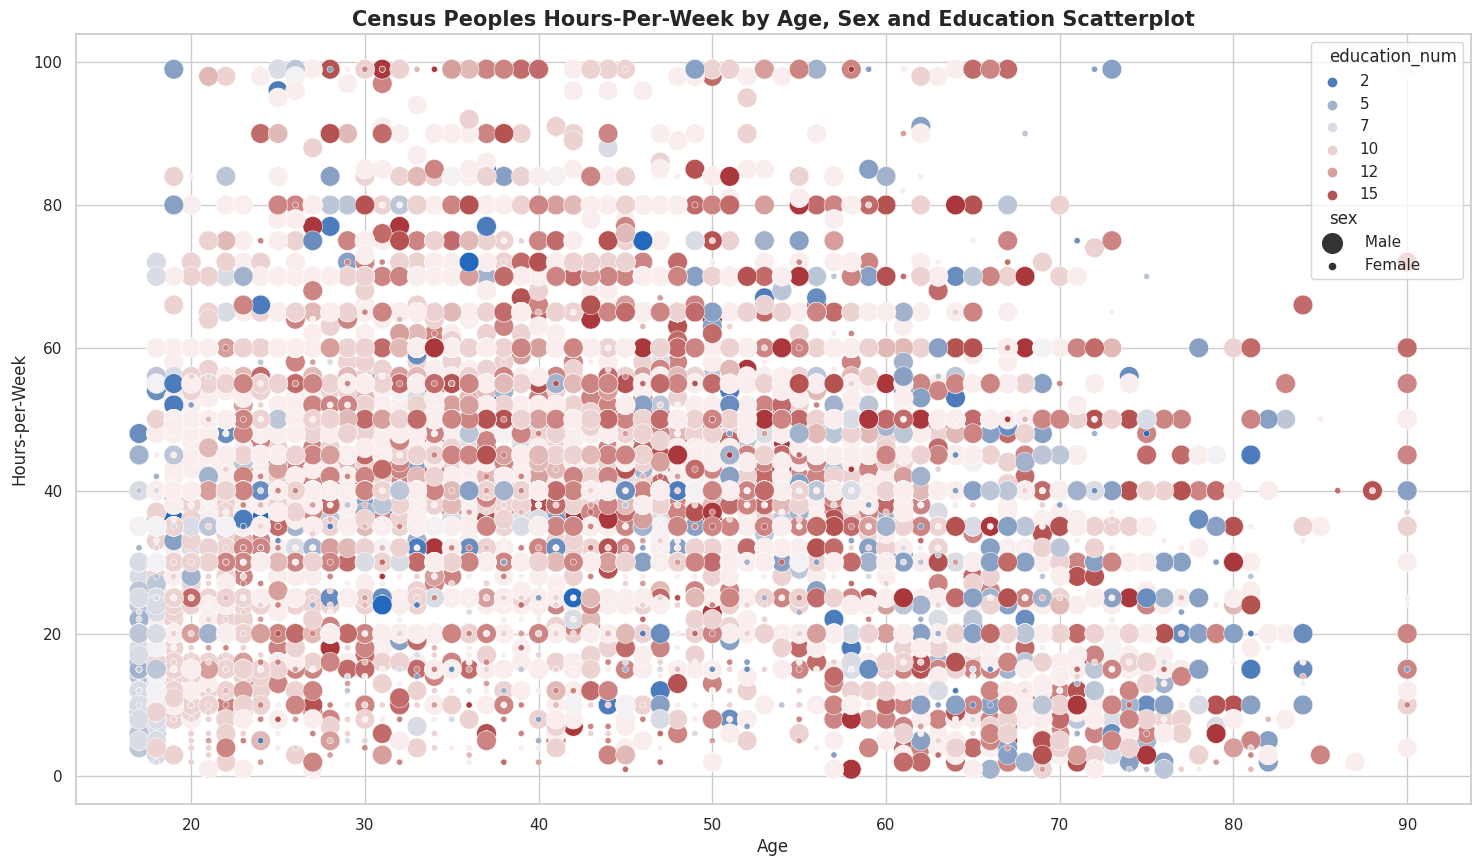

In [56]:
plt.figure(figsize=(18,10))
gfg = sns.scatterplot(data=df_orig_copy,
                x='age',
                y='hours_per_week',
                size='sex',
                hue='education_num',
                sizes=(20,200),
                palette="vlag") #'Blues_r')

title = 'Census Peoples Hours-Per-Week by Age, Sex and Education Scatterplot'
plt.title(title, fontsize=15, fontweight='bold')
gfg.set(xlabel='Age', ylabel='Hours-per-Week')
plot_name = 'hoursPerWeek_dist_age-education-sex_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show()

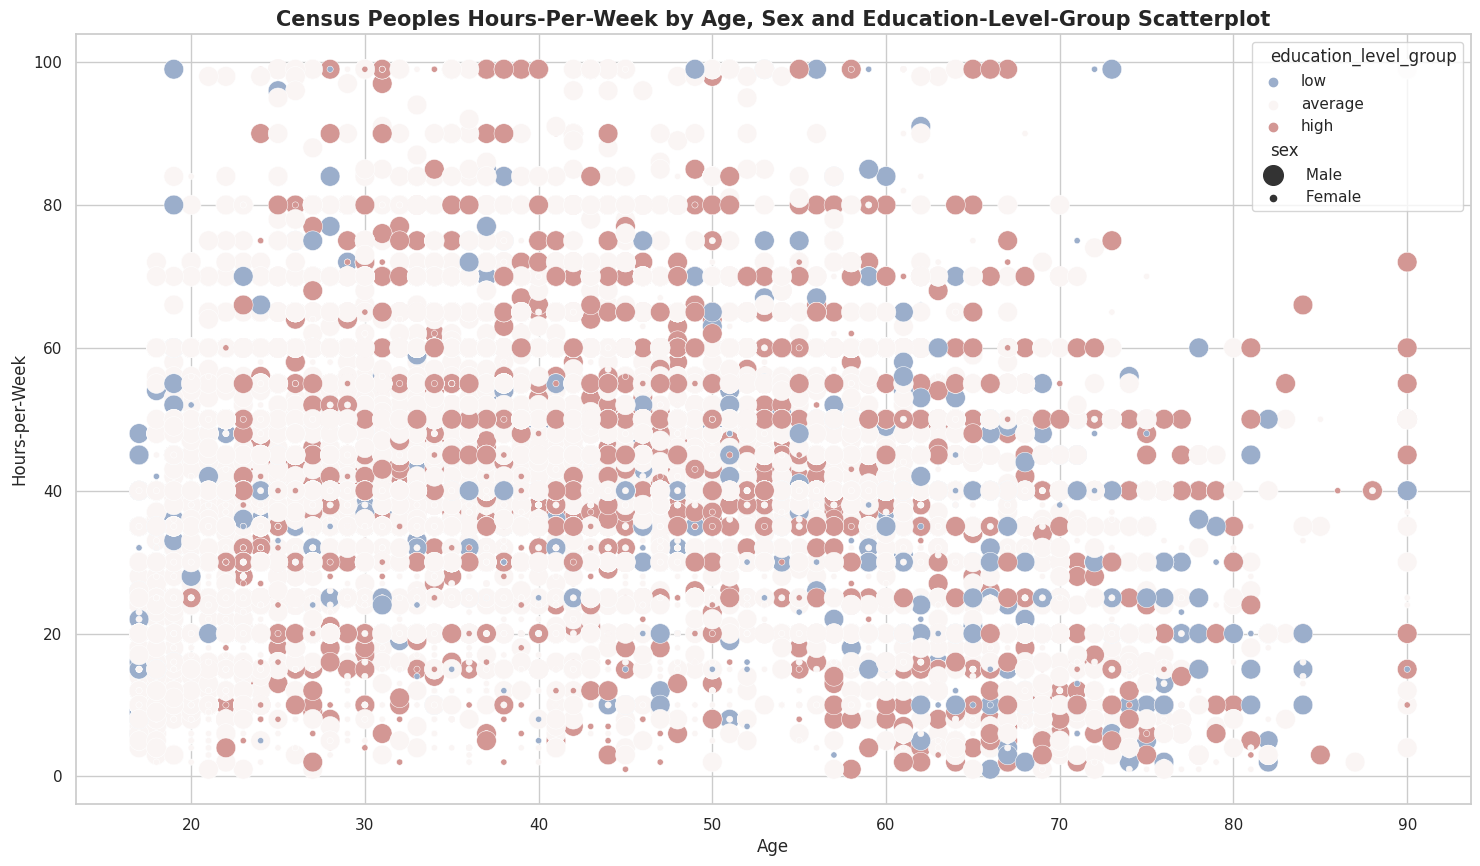

In [57]:
plt.figure(figsize=(18,10))
gfg = sns.scatterplot(data=df_orig_copy,
                x='age',
                y='hours_per_week',
                size='sex',
                hue='education_level_group',
                sizes=(20,200),
                palette="vlag") #'Blues_r')
title = 'Census Peoples Hours-Per-Week by Age, Sex and Education-Level-Group Scatterplot'
plt.title(title, fontsize=15, fontweight='bold')
gfg.set(xlabel='Age', ylabel='Hours-per-Week')
plot_name = 'hoursPerWeek_dist_age-educationLevel-sex_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show()

**Note:** Regarding hours-per-week male, independent from education, work much longer with paid work compared to female.

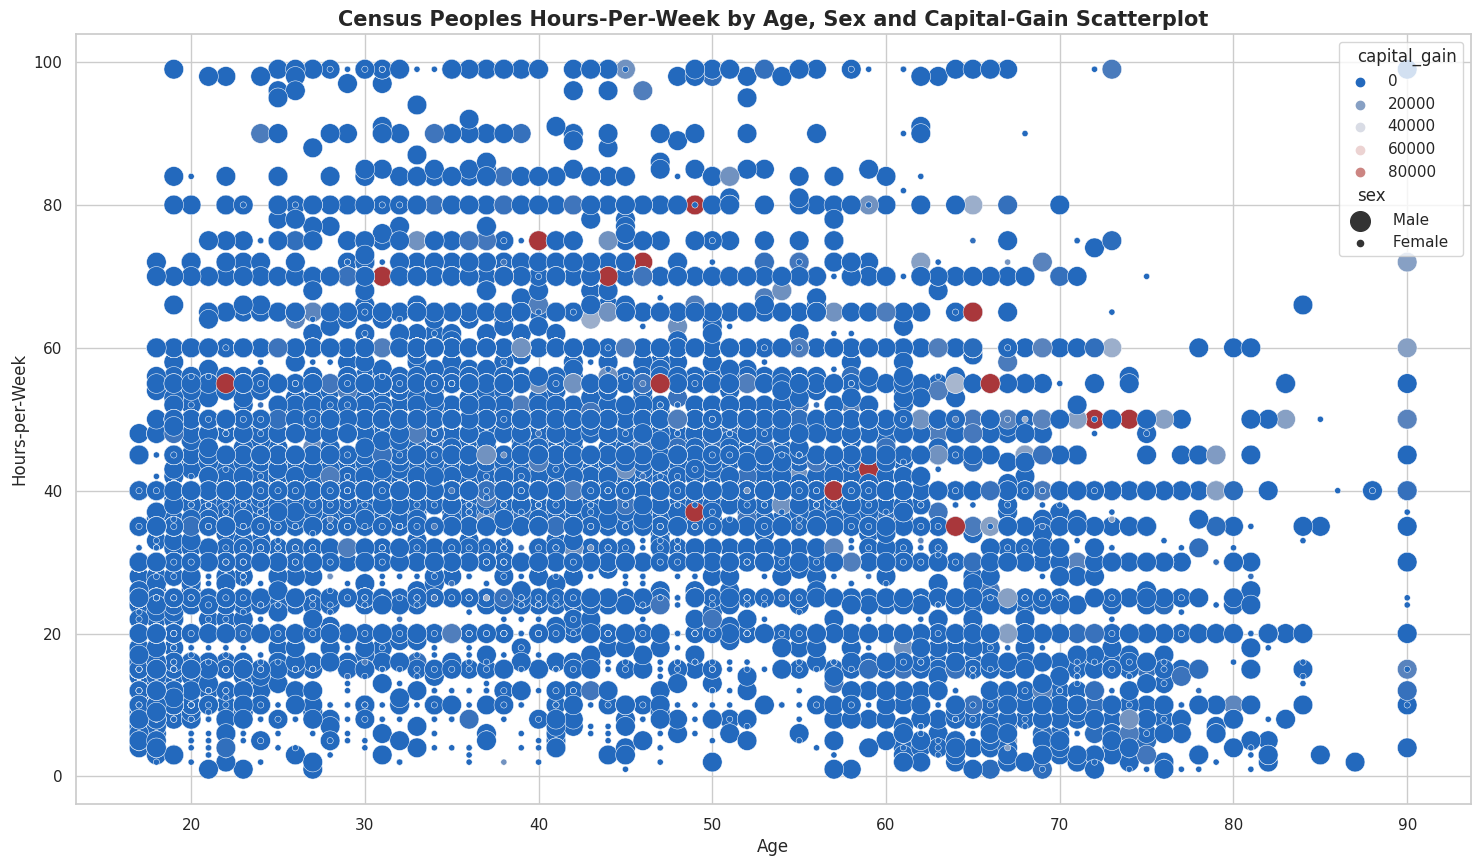

In [58]:
# capital_gain (German translation: Kapitalerträge)

plt.figure(figsize=(18,10))
gfg = sns.scatterplot(data=df_orig_copy,
                x='age',
                y='hours_per_week',
                size='sex',
                hue='capital_gain',
                sizes=(20,200),
                palette="vlag")

title = 'Census Peoples Hours-Per-Week by Age, Sex and Capital-Gain Scatterplot'
plt.title(title, fontsize=15, fontweight='bold')
gfg.set(xlabel='Age', ylabel='Hours-per-Week')
plot_name = 'hoursPerWeek_dist_age-capitalGain-sex_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show();

**Note:** In general, with an average working hour around 40 few male people are getting high capital-gain, if they are at age around 50 or 60. Only with hours-per-week > 50 up to 80 male people independent from age are getting high capital-gain. So, one insight is that much higher hours-per-week compared to the average 40-hours-week is no guarantee for additional high value of money (resp. capital-gain). Most people don't have any kind of capital-gain.

**Next question:** Is there a relation of having capital-gain and associated sex and education level of the people? It is expected that with higher education and being male, the probability of having a high capital-gain is much higher compared to other sex groups.

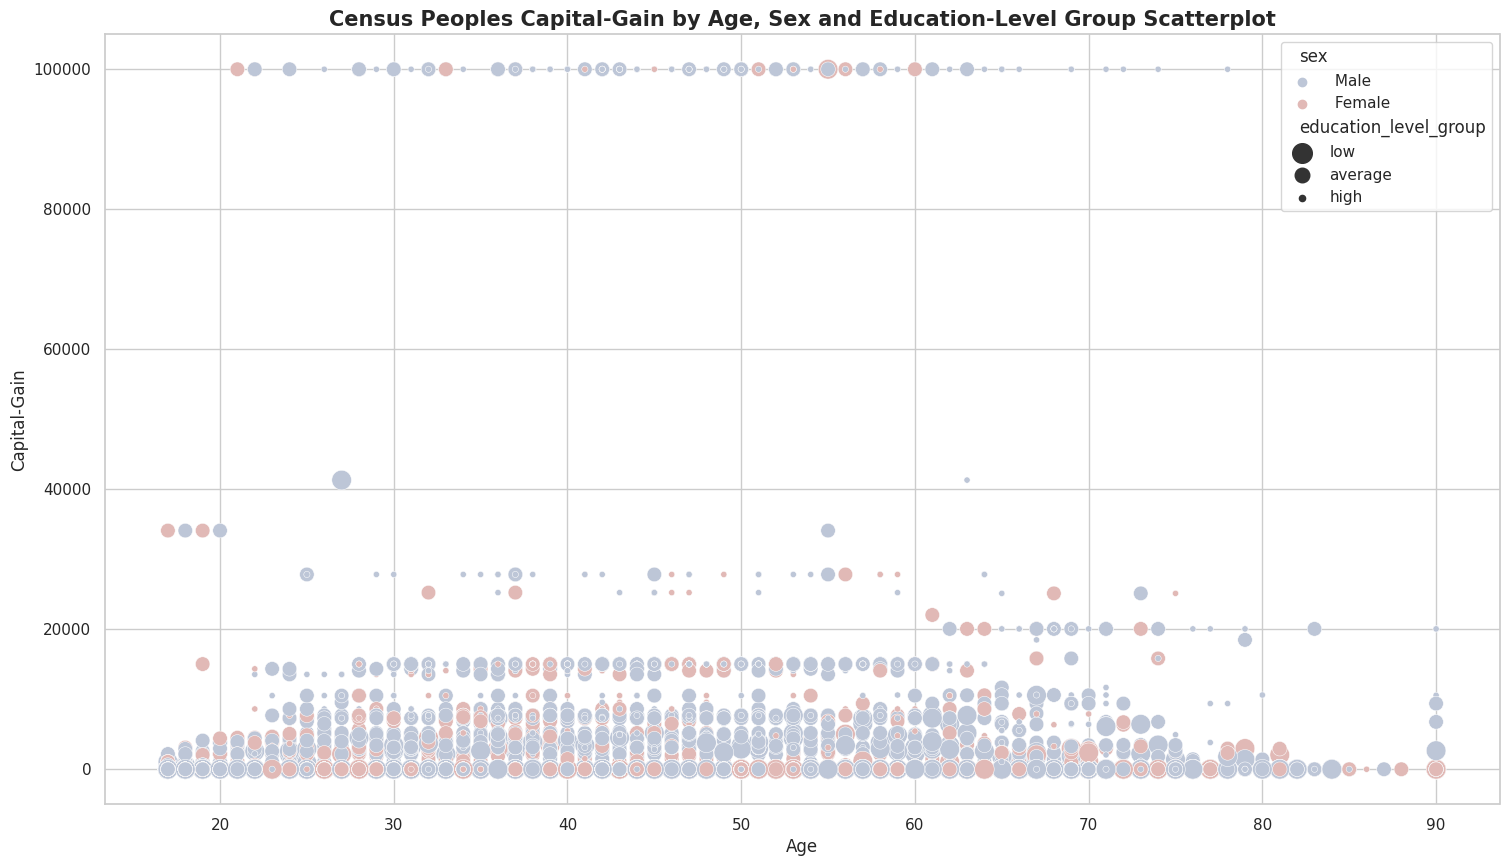

In [59]:
plt.figure(figsize=(18,10))
gfg = sns.scatterplot(data=df_orig_copy,
                x='age',
                y='capital_gain',
                size='education_level_group',
                hue='sex',
                sizes=(20,200),
                palette="vlag")

title = 'Census Peoples Capital-Gain by Age, Sex and Education-Level Group Scatterplot'
plt.title(title, fontsize=15, fontweight='bold')
gfg.set(xlabel='Age', ylabel='Capital-Gain')
plot_name = 'capitalGain_dist_age-sex-educationLevel_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show();

**Note:** As expected, most people have no capital-gain, followed by having a low amount of extra money. Furthermore, people with capital-gain are mainly of age 22 up to 63 with a high or average education level.

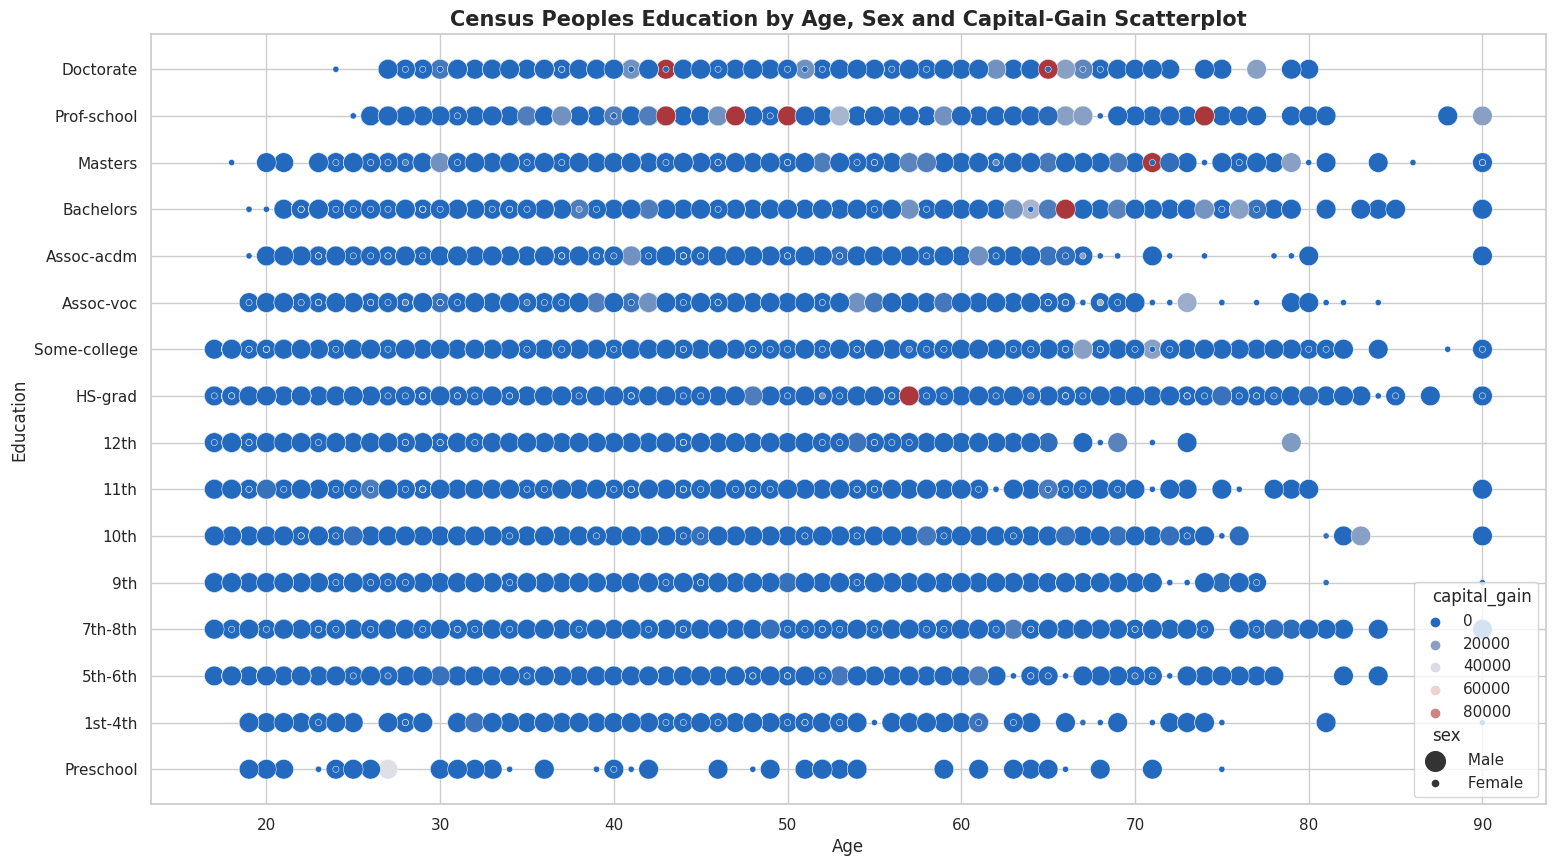

In [60]:
plt.figure(figsize=(18,10))
gfg = sns.scatterplot(data=df_orig_copy,
                x='age',
                y='education_num',
                size='sex',
                hue='capital_gain',
                sizes=(20,200),
                palette="vlag")

title = 'Census Peoples Education by Age, Sex and Capital-Gain Scatterplot'
plt.title(title, fontsize=15, fontweight='bold')
gfg.set(xlabel='Age', ylabel='Education')
yticklabels = ['Preschool', '1st-4th', '5th-6th', '7th-8th',
               '9th', '10th', '11th', '12th',
               'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm',
               'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
gfg.set_yticks(ticks=list(range(1, 17)), labels=yticklabels)
plot_name = 'education_dist_age-capitalGain-sex_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight')
plt.show();

**Note:** Some insights:
- few highest capital_gain being male sex dependent is available with education _doctorate_, _prof-school_
- few highest capital_gain being male dependent is available with education _HS-grad, _bachelors_, _masters_
- some male with higher or average education have capital-gain up to 40000$
-  most people independent from education or sex don't have any kind of capital-gain

<a id='3.'></a>
### 3. Further Feature Engineering
We have identified the following, remaining **categorical features**:
- 'workclass'
- 'marital_status'
- 'occupation'
- 'relationship'
- 'race'
- 'sex'
- 'native_country'

and according our profiling report of the original data _race_ is highly imbalanced (65.6%) and 'native_country' is highly imbalanced (82.5%) as well. Furthermore, even it is wrong from medical point of view, the sex attribute in this dataset is a binary one. Take care of this during pipeline creation and its scaling topic.<br>

Addionally, our target feature _salary_ is imbalanced as well, regarding its classes. As a consequence, we have to chose an appropriate model estimator for our **binary classification prediction** having a salary >50k or not. In general, tree-based algorithms (like the ensemble _RandomForestClassifier_) or boosting algorithms (_AdaBoostClassifier_, _XGBoostClassifier_)


Regarding this dataset features, there are still other open questions:
- Regarding the categorical features, what is the detailed cardinality of the attributes? If the number is 'too high' this is not valuable. What 'too high' means is unclear by now. Is it necessary to create another bin structure?
- Regarding the categorical features, we shall do an encoding. Their interpretation - having a ranking or not - cannot be distinguished by a prediction model.

In [61]:
def print_categorical_group(cat_feat):
    ''' Prints the amount of the categorical feature values. '''
    
    txt_start = "There are "
    txt_feat = " " + str(cat_feat) + " values "
    txt_middle = "with "
    txt_nan = " NaN's "
    txt_end = "in the census dataset:\n"
    print(esc('1') + txt_start + esc('34;1') + \
          str(df_orig_copy[cat_feat].nunique()) + txt_feat + \
          esc('0') + esc('1') + txt_middle + esc('34;1') + \
          str(df_orig_copy[cat_feat].isna().sum()) + txt_nan + \
          esc('0') + esc('1') + txt_end + esc('0'))
    df_group = df_orig_copy.groupby(cat_feat)
    print(df_group[cat_feat].count())

#### 3.1 Feature 'workclass'

In [62]:
print_categorical_group('workclass')

There are 9 workclass values with 0 NaN's in the census dataset:

workclass
 ?                    1836
 Federal-gov           960
 Local-gov            2093
 Never-worked            7
 Private             22673
 Self-emp-inc         1116
 Self-emp-not-inc     2540
 State-gov            1298
 Without-pay            14
Name: workclass, dtype: int64


#### 3.2 Feature 'marital_status'

In [63]:
print_categorical_group('marital_status')

There are 7 marital_status values with 0 NaN's in the census dataset:

marital_status
 Divorced                  4441
 Married-AF-spouse           23
 Married-civ-spouse       14970
 Married-spouse-absent      418
 Never-married            10667
 Separated                 1025
 Widowed                    993
Name: marital_status, dtype: int64


#### 3.3 Feature 'occupation'

In [64]:
print_categorical_group('occupation')

There are 15 occupation values with 0 NaN's in the census dataset:

occupation
 ?                    1843
 Adm-clerical         3768
 Armed-Forces            9
 Craft-repair         4094
 Exec-managerial      4065
 Farming-fishing       992
 Handlers-cleaners    1369
 Machine-op-inspct    2000
 Other-service        3291
 Priv-house-serv       147
 Prof-specialty       4136
 Protective-serv       649
 Sales                3650
 Tech-support          927
 Transport-moving     1597
Name: occupation, dtype: int64


#### 3.4 Feature 'relationship'

In [65]:
print_categorical_group('relationship')

There are 6 relationship values with 0 NaN's in the census dataset:

relationship
 Husband           13187
 Not-in-family      8292
 Other-relative      981
 Own-child          5064
 Unmarried          3445
 Wife               1568
Name: relationship, dtype: int64


#### 3.5 Feature 'race'

In [66]:
print_categorical_group('race')

There are 5 race values with 0 NaN's in the census dataset:

race
 Amer-Indian-Eskimo      311
 Asian-Pac-Islander     1038
 Black                  3122
 Other                   271
 White                 27795
Name: race, dtype: int64


#### 3.6 Feature 'sex'

In [67]:
print_categorical_group('sex')

There are 2 sex values with 0 NaN's in the census dataset:

sex
 Female    10762
 Male      21775
Name: sex, dtype: int64


#### 3.7 Feature 'native_country'

In [68]:
print_categorical_group('native_country')

There are 42 native_country values with 0 NaN's in the census dataset:

native_country
 ?                               582
 Cambodia                         19
 Canada                          121
 China                            75
 Columbia                         59
 Cuba                             95
 Dominican-Republic               70
 Ecuador                          28
 El-Salvador                     106
 England                          90
 France                           29
 Germany                         137
 Greece                           29
 Guatemala                        62
 Haiti                            44
 Holand-Netherlands                1
 Honduras                         13
 Hong                             20
 Hungary                          13
 India                           100
 Iran                             43
 Ireland                          24
 Italy                            73
 Jamaica                          81
 Japan                   

As visible, these are partly highly imbalanced features and sometimes the _?_ (question mark) is used to indicate unknown values. We have to take care of that workflow.

#### 3.8 Additional Preprocessing Steps
**Insights**:
- no NaN values are available, but have in mind this could be the case in a future dataset
- the _?_ character sign is used for unknown values of few columns. This has to be changed, so, we replace it with the word _Other_
- there are round about half as much female participants compared to male ones. Which other attributes are not normal distributed? Do some [scipy normal testing](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) that tests the null hypothesis that a sample comes from a normal distribution. The resulting statistic value of the associated feature tends to be low for samples drawn from a normal distribution.
- the dataset has _some non-gaussian attribute distributions_, some of them can be changed by additional feature engineering; like scaling or another bin grouping, so, its cardinality is much more comparable to the other attributes.
- As mentioned we have to take care of the classification model type selection. In general, ML algorithm will ignore such imbalance of the target classes which could lead to bias issues. In our case, the **salary distribution** is: 
   - _<=50K_ has 24698 items
   - _>50K_ has 7839 items
   
But if the minority class is more important and the performance of the selected model type is still not acceptable, we can change the dataset e.g. by using _Synthetic Minority Oversampling Technique_, or _SMOTE_ for short.<br>
Nevertheless, first we start by using _RandomForestClassiefier_ and _XGBoostClassifier_, because they can handle the imbalanced dataset property themselves.

In [69]:
# example for ? sign ...
df_orig_copy['native_country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [70]:
# replace ?
df_orig_copy.replace(to_replace=[' ?', '?', '? ', ' ? '], value='Other', inplace=True)

In [71]:
# make sure it is always called 'Other' and no mixture exists
df_orig_copy.replace(to_replace=['Others', 'others', 'other'], value='Other', inplace=True)

As visible with this example, not only column label strings included leading or trailing spaces, the column string values are effected as well. So, we have to remove them from such strings too in the entire dataframe.

In [72]:
df_orig_copy = df_orig_copy.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [73]:
df_orig_copy['native_country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', 'Other', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [74]:
df_orig_copy['race'].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

Now, we do **normal distribution testing** of some features, delivering probability plots and gaussian statistical value of normal test function. Sure, we could interpret already our histograms, but this more robust.

A _significance level_ of 0.05 indicates a 5% risk of concluding that the data do not follow a normal distribution when the other data do follow a normal distribution. P-value ≤ α: The data do not follow a normal distribution (Reject H0 hypothesis)

For numerical features we use the _normaltest()_ function from the scipy library. For categorical features this function cannot be used. For them we look at the histograms of this notebooks visualisation part in chapter 2.1. There it is visible that no categorical attribute has a normal gaussian distribution.

In [75]:
def plot_normaldist_prob(feat):
    ''' 
    Plots statistical feature distributions and
    its normal test statistics with p-value resp. associated gaussian result.
    '''
    measurements = df_orig_copy[feat]
    
    # first probability plot
    fig = plt.figure(figsize=(4.8,3))
    ax = fig.add_subplot(111)
    stats.probplot(measurements, dist='norm', plot=pylab)
    ax.get_lines()[0].set_markersize(2.0)
    
    # second plot
    plt.figure(figsize=(4.5,3))
    sns.histplot(measurements, binwidth=2.5, kde=True, alpha=.5,
                 stat="density", kde_kws=dict(cut=3))
    
    # wait until the plotting is ready
    plt.show(block=False)

    # statistic calculations
    stat,p = normaltest(measurements)
    print(esc('4;1') + 'Calculation' + esc('0'))
    print('stat=%.3f, p=%.3f\n' % (stat, p))
    print(esc('4;1') + 'Result for feature ' + esc('34') + str(feat) + esc('0'))
    
    if p > 0.05:
      print(esc('92;1') + 'probably gaussian' + esc('0'))
    else:
      print(esc('91;1') + 'probably non-gaussian' + esc('0'))

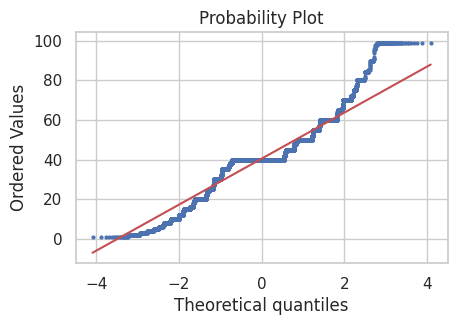

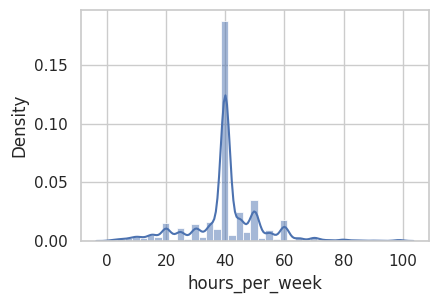

Calculation
stat=2510.467, p=0.000

Result for feature hours_per_week
probably non-gaussian


In [76]:
plot_normaldist_prob('hours_per_week')

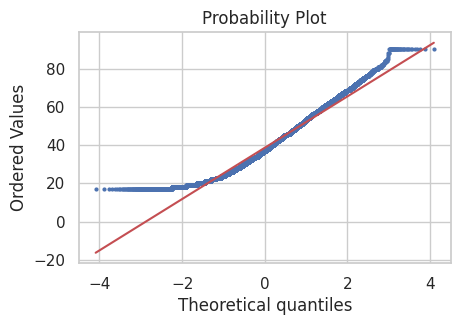

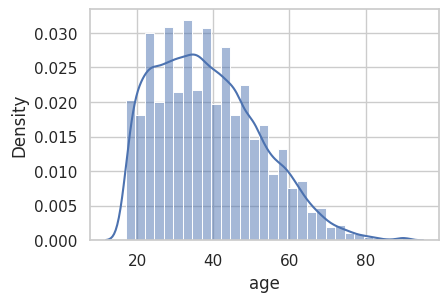

Calculation
stat=1522.051, p=0.000

Result for feature age
probably non-gaussian


In [77]:
plot_normaldist_prob('age')

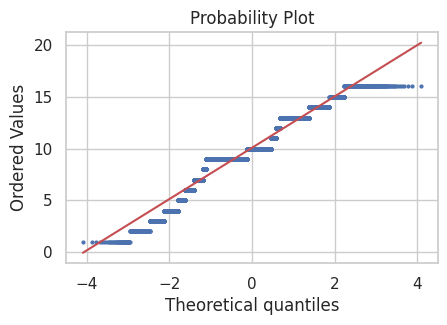

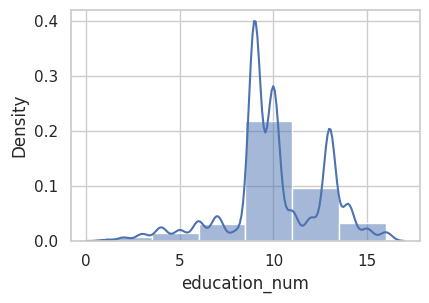

Calculation
stat=806.413, p=0.000

Result for feature education_num
probably non-gaussian


In [78]:
plot_normaldist_prob('education_num')

So, no feature has a real normal, gaussian distribution with its values.

**Next topic** is the analysis of the features **cardinality**. Have in mind, our additionally created attributes are still part of the dataframe.

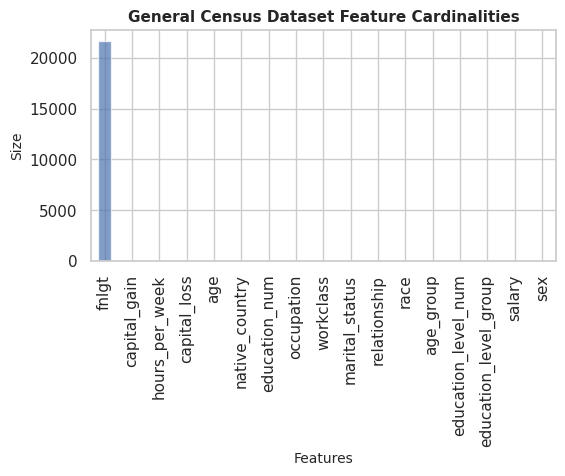

In [79]:
df_orig_copy.loc[:].nunique().sort_values(ascending=False).plot.bar(figsize=(6, 3), alpha=0.7)
plt.ylabel('Size', fontsize=10)
plt.xlabel('Features', fontsize=10)
plt.title('General Census Dataset Feature Cardinalities', fontsize=11, fontweight='bold');

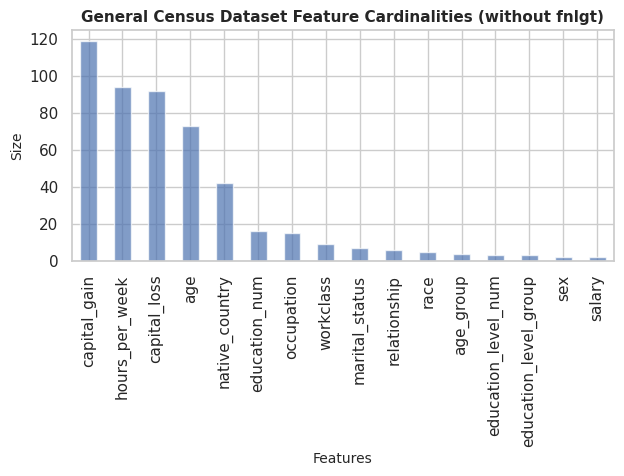

In [80]:
# do the same without fnlgt attribute, getting an overview of the other ones
df_orig_copy.loc[:, ~df_orig_copy.columns.isin(['fnlgt'])].nunique().sort_values(ascending=False).plot.bar(figsize=(7, 3), alpha=0.7)
plt.ylabel('Size', fontsize=10)
plt.xlabel('Features', fontsize=10)
plt.title('General Census Dataset Feature Cardinalities (without fnlgt)', fontsize=11, fontweight='bold')
plot_name = 'census_cardinality_notFnlgt_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight');

**Note:** Regarding cardinality only the attribute _fnlgt_ has to be changed, all others are fine. So, now we create new bins for fnlgt to reduce the amount of value variation.

In [81]:
print(f"max value of column fnlgt: {max(df_orig_copy['fnlgt'])}")

max value of column fnlgt: 1484705


In [82]:
print(f"min value of column fnlgt: {min(df_orig_copy['fnlgt'])}")

min value of column fnlgt: 12285


In [83]:
# note: set has a better performance compared to list, but throws TypeError in cut()
r = list(range(0, 1550000, 50000))
print(f'x in range: {r}')

x in range: [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000, 1050000, 1100000, 1150000, 1200000, 1250000, 1300000, 1350000, 1400000, 1450000, 1500000]


In [84]:
df_orig_copy['mod_fnlgt'] = pd.cut(df_orig_copy['fnlgt'], r, right=False, labels=False)

In [85]:
df_orig_copy['mod_fnlgt'].unique()

array([ 1,  4,  6,  5,  3,  0,  2,  7, 10,  8,  9, 12, 17, 20, 11, 13, 15,
       18, 14, 23, 19, 24, 16, 29, 25, 27, 21, 22])

In [86]:
df_orig_copy.loc[df_orig_copy['mod_fnlgt'].isna()]

Empty DataFrame
Columns: [age, workclass, fnlgt, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, salary, education_level_num, age_group, education_level_group, mod_fnlgt]
Index: []

In [87]:
df_orig_copy['mod_fnlgt'] = df_orig_copy['mod_fnlgt'].apply(lambda value: r[value+1])

In [88]:
df_orig_copy.head(10)

age         workclass   fnlgt  education_num         marital_status  \
0   39         State-gov   77516             13          Never-married   
1   50  Self-emp-not-inc   83311             13     Married-civ-spouse   
2   38           Private  215646              9               Divorced   
3   53           Private  234721              7     Married-civ-spouse   
4   28           Private  338409             13     Married-civ-spouse   
5   37           Private  284582             14     Married-civ-spouse   
6   49           Private  160187              5  Married-spouse-absent   
7   52  Self-emp-not-inc  209642              9     Married-civ-spouse   
8   31           Private   45781             14          Never-married   
9   42           Private  159449             13     Married-civ-spouse   

          occupation   relationship   race     sex  capital_gain  \
0       Adm-clerical  Not-in-family  White    Male          2174   
1    Exec-managerial        Husband  White    Male             0   
2  Handlers-cleaners  Not-in-family  White    Male             0   
3  Handlers-cleaners        Husband  Black    Male             0   
4     Prof-specialty           Wife  Black  Female             0   
5    Exec-managerial           Wife  White  Female             0   
6      Other-service  Not-in-family  Black  Female             0   
7    Exec-managerial        Husband  White    Male             0   
8     Prof-specialty  Not-in-family  White  Female         14084   
9    Exec-managerial        Husband  White    Male          5178   

   capital_loss  hours_per_week native_country  salary  education_level_num  \
0             0              40  United-States       0                    3   
1             0              13  United-States       0                    3   
2             0              40  United-States       0                    2   
3             0              40  United-States       0                    2   
4             0              40           Cuba       0                    3   
5             0              40  United-States       0                    3   
6             0              16        Jamaica       0                    1   
7             0              45  United-States       1                    2   
8             0              50  United-States       1                    3   
9             0              40  United-States       1                    3   

  age_group education_level_group  mod_fnlgt  
0     adult                  high     100000  
1     adult                  high     100000  
2     adult               average     250000  
3     older               average     250000  
4     adult                  high     350000  
5     adult                  high     300000  
6     adult                   low     200000  
7     older               average     250000  
8     adult                  high      50000  
9     adult                  high     200000

**Finally,** we have to remove the additionally created attributes used during this EDA, which are:
- age_group
- education_level_num
- education_level_group

and the original _fnlgt_. Then we create another profiling report with the modified dataset.

In [89]:
df_orig_copy.drop(columns=['fnlgt', 'age_group', 'education_level_num', 'education_level_group'], inplace=True)

In [90]:
df_orig_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32537 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   education_num   32537 non-null  int64 
 3   marital_status  32537 non-null  object
 4   occupation      32537 non-null  object
 5   relationship    32537 non-null  object
 6   race            32537 non-null  object
 7   sex             32537 non-null  object
 8   capital_gain    32537 non-null  int64 
 9   capital_loss    32537 non-null  int64 
 10  hours_per_week  32537 non-null  int64 
 11  native_country  32537 non-null  object
 12  salary          32537 non-null  int64 
 13  mod_fnlgt       32537 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.7+ MB


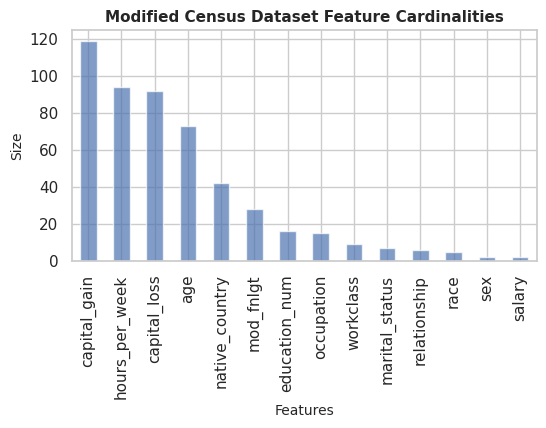

In [91]:
df_orig_copy.loc[:].nunique().sort_values(ascending=False).plot.bar(figsize=(6, 3), alpha=0.7)
plt.ylabel('Size', fontsize=10)
plt.xlabel('Features', fontsize=10)
plt.title('Modified Census Dataset Feature Cardinalities', fontsize=11, fontweight='bold')
plot_name = 'census_cardinality_modifiedDataset_plot.png'
plt.savefig(config['eda']['plots_path']+str(plot_name), bbox_inches='tight');

In [92]:
# create profiling report of modified, preprocessed census data
profile = ProfileReport(df_orig_copy,
                        title=str(config['eda']['preproc_report_title']))

In [93]:
profile.to_file(str(config['eda']['preproc_census_report']))
logger.info(f"EDA report stored as {config['eda']['preproc_census_report']}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

2023-08-25 15:54:20,160 - MainThread - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff11dfa5cf0> - 857


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

2023-08-25 15:54:22,582 - MainThread - staging - INFO - EDA report stored as ./eda_census_preproc_report.html - 2


**Note:** Regarding the new profiling report, now, there are some duplicates again (2.2%). In other words the only difference in the original dataset has been the _fnlgt_ feature. So not having found information about the meaning and importance of this specific attribute, we will remove this new duplicate rows as well. There are still enough items.

In [94]:
# still using the original index values
df_orig_copy.drop_duplicates(inplace=True, ignore_index=False)

In [95]:
df_orig_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31664 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             31664 non-null  int64 
 1   workclass       31664 non-null  object
 2   education_num   31664 non-null  int64 
 3   marital_status  31664 non-null  object
 4   occupation      31664 non-null  object
 5   relationship    31664 non-null  object
 6   race            31664 non-null  object
 7   sex             31664 non-null  object
 8   capital_gain    31664 non-null  int64 
 9   capital_loss    31664 non-null  int64 
 10  hours_per_week  31664 non-null  int64 
 11  native_country  31664 non-null  object
 12  salary          31664 non-null  int64 
 13  mod_fnlgt       31664 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.6+ MB


In [96]:
df_orig_copy.tail()

age     workclass  education_num      marital_status       occupation  \
32554   53       Private             14  Married-civ-spouse  Exec-managerial   
32555   22       Private             10       Never-married  Protective-serv   
32556   27       Private             12  Married-civ-spouse     Tech-support   
32558   58       Private              9             Widowed     Adm-clerical   
32560   52  Self-emp-inc              9  Married-civ-spouse  Exec-managerial   

        relationship   race     sex  capital_gain  capital_loss  \
32554        Husband  White    Male             0             0   
32555  Not-in-family  White    Male             0             0   
32556           Wife  White  Female             0             0   
32558      Unmarried  White  Female             0             0   
32560           Wife  White  Female         15024             0   

       hours_per_week native_country  salary  mod_fnlgt  
32554              40  United-States       1     350000  
32555              40  United-States       0     350000  
32556              38  United-States       0     300000  
32558              40  United-States       0     200000  
32560              40  United-States       1     300000

<a id='4.'></a>
### 4. Load
The modified census dataset is stored as .csv file via pandas library. In the GitHub repository it is versioned with dvc.

In [97]:
try:
    df_orig_copy.to_csv(config['etl']['preproc_census'])
    logger.info(f"Preprocessed census dataset stored as {config['etl']['preproc_census']}")
except:
    logger.error("Preprocessed US census dataset could not be stored... !")

2023-08-25 15:54:22,884 - MainThread - staging - INFO - Preprocessed census dataset stored as ../../data/preproc_census.csv - 3
